In [25]:
# Imports and directories
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import petTOAD_exploratory_analysis_not_wmh as sim

NOT_WMH_DIR = RES_DIR / "exploratory_not_wmh_weighted"

In [94]:
def annotate_star(tbl):
    """
    This function is just to plot a start at the best heatmap value for better recognition
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): "*"})
    return star


def save_plot_results(res_df, group):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn needs to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """

    # Convert the result df into a pivot table so to plot heatmap
    table_fc = pd.pivot_table(
        res_df, values="fc_pearson", index="a", columns="G"
    ).astype(float)
    # Skip fcd for now
    # table_fcd = pd.pivot_table(res_df, values='fcd_ks', index='b', columns='w').astype(float)
    table_phfcd = pd.pivot_table(
        res_df, values="phfcd_ks", index="a", columns="G"
    ).astype(float)
    # Create a composite score by summing up the single model fits so to choose when FC and phFCD have different "best" b-w combinations
    table_sum = table_fc + table_phfcd
    # Create Heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ax=axs[0],
        data=table_fc,
        annot=annotate_star(table_fc),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[0].set_title(f"FC", fontsize=9)

    sns.heatmap(
        ax=axs[1],
        data=table_phfcd,
        annot=annotate_star(table_phfcd),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[1].set_title(f"1 - phFCD", fontsize=9)
    sns.heatmap(
        ax=axs[2],
        data=table_sum,
        annot=annotate_star(table_sum),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[2].set_title(f"FC + (1 - phFCD)", fontsize=9)
    savename = f"{group}_results_heatmap.png"
    fig.suptitle(f"{group}")
    fig.tight_layout()
    plt.savefig(NOT_WMH_DIR / savename)




def perform_group_analyses(big_df):
    """
    This function allow us to select the grouping classification (Fazekas 1, Fazekas 2 or all) as the 'group'variable and then it selects
    only HC and MCI with WMH based on the chosen classification (since we are not interested for this type of model in patients without WMH).
    Then, calls the save_plot_results function, which plots and saves a summary heatmap of the mean FC and 1-phFCD across all patients that fall
    into a category (HC or MCI) according to the chosen grouping.

    Args:
        adnimerge:
        big_df:
        group:
        random:

    Returns:
        Nothing
    """
    hc_no_wmh_df = big_df[big_df["PTID"].isin(sim.HC_no_WMH)]
    hc_no_wmh_grouped = hc_no_wmh_df.drop(columns=["PTID"]).groupby(["a", "G"]).mean()
    save_plot_results(hc_no_wmh_grouped, "hc_no_wmh")

    hc_wmh_df = big_df[big_df["PTID"].isin(sim.HC_WMH)]
    hc_wmh_grouped = hc_wmh_df.drop(columns=["PTID"]).groupby(["a", "G"]).mean()
    save_plot_results(hc_wmh_grouped, "hc_wmh")

    mci_no_wmh_df = big_df[big_df["PTID"].isin(sim.MCI_no_WMH)]
    mci_no_wmh_grouped = mci_no_wmh_df.drop(columns=["PTID"]).groupby(["a", "G"]).mean()
    save_plot_results(mci_no_wmh_grouped, "mci_no_wmh")


    mci_wmh_df = big_df[big_df["PTID"].isin(sim.MCI_WMH)]
    mci_wmh_grouped = mci_wmh_df.drop(columns=["PTID"]).groupby(["a", "G"]).mean()
    save_plot_results(mci_wmh_grouped, "mci_wmh")


def get_best_dfs(big_df, fc_name, phfcd_name):
    # Get the best model fits for fc, phfcd for each subject and create one single df (skip fcd for now)
    res_df_best = pd.DataFrame(
        {
            fc_name: big_df.groupby(["PTID"])[fc_name].max(),
            phfcd_name: big_df.groupby(["PTID"])[phfcd_name].max(),
        }
    ).reset_index()

    res_df_best["wmh_load"] = [wmh_dict[subj] for subj in res_df_best["PTID"]]
    # This df is to check what are the best w, b in case of the best fc and best phfcd
    # First we group by each patient and get the max fc pearson for each
    # Then we merge this df (with the name of pt and max fc) with the df containing also b and w
    # so we have: max(FC), b, w for each patient
    max_fc_vals = big_df.groupby(["PTID"])[fc_name].max().reset_index()
    merged_df_max_fc = pd.merge(big_df, max_fc_vals, on=["PTID", fc_name])
    # We do the same for 1-phFCD
    max_phfcd_vals = big_df.groupby(["PTID"])[phfcd_name].max().reset_index()
    merged_df_max_phfcd = pd.merge(big_df, max_phfcd_vals, on=["PTID", phfcd_name])

    return merged_df_max_fc, merged_df_max_phfcd


In [303]:
# Load the clinical dataframe with the groupings
adnimerge = pd.read_csv(RES_DIR / "petTOAD_dataframe.csv")
adnimerge["PTID"] = adnimerge["PTID"].str.replace("_", "")
wmh_dict = get_wmh_load_homogeneous(subjs)
df_big = pd.DataFrame()
for subj in sim.short_subjs:
    df_subj = pd.read_csv(NOT_WMH_DIR / f"sub-{subj}_df_results_initial_exploration_not_wmh.csv", index_col = 0)
    if subj in sim.HC:
        df_subj["group"] = "HC"
    elif subj in sim.MCI:
        df_subj["group"] = "MCI"
    df_subj["PTID"] = subj
    df_subj["wmh"] = wmh_dict[subj]
    df_subj["phfcd_ks"] = 1 - df_subj["phfcd_ks"]
    df_subj["comp_score"] = df_subj["fc_pearson"] + 2*df_subj["phfcd_ks"]
    df_big = pd.concat([df_big, df_subj])
df_max_fc, df_max_phfcd = get_best_dfs(df_big, "fc_pearson", "phfcd_ks")


In [304]:
df_mean_hc = df_big[df_big["group"] == "HC"].drop(columns=["PTID", "group", "wmh"]).groupby(["a", "G"]).mean().reset_index()
df_mean_mci = df_big[df_big["group"] == "MCI"].drop(columns=["PTID", "group", "wmh"]).groupby(["a", "G"]).mean().reset_index()
df_mean_subj = df_subj.drop(columns=["PTID", "group", "wmh"]).groupby(["a", "G"]).mean().reset_index()

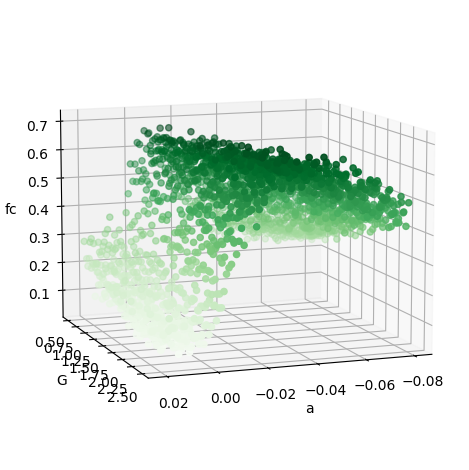

In [255]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df_mean_hc["phfcd_ks"]
xdata = df_mean_hc["a"]
ydata = df_mean_hc["G"]

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
ax.set_xlabel("a")
ax.set_ylabel("G")
ax.set_zlabel("fc")
ax.view_init(10, 70)
fig.tight_layout()

In [315]:
def plot_3d_maps(df):
    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize = plt.figaspect(0.33))

    # =============
    # First subplot
    # =============
    # set up the axes for the first plot
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')

    # plot a 3D surface like in the example mplot3d/surface3d_demo

    # Data for three-dimensional scattered points
    z1 = df["fc_pearson"]
    x = df["a"]
    y = df["G"]

    surf = ax1.plot_trisurf(x, y, z1, cmap='viridis');
    ax1.set_xlabel("a")
    ax1.set_ylabel("G")
    ax1.set_zlabel("FC")
    ax1.set_zlim(0, 1.01)
    # Choose how to rotate the "camera"
    ax1.view_init(20, 100)

    fig.colorbar(surf, shrink=0.5, aspect=10)
    # ==============
    # Second subplot
    # ==============
    # set up the axes for the second plot
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')

    # plot a 3D wireframe like in the example mplot3d/wire3d_demo
    z2 = df["phfcd_ks"]

    surf2 = ax2.plot_trisurf(x, y, z2, cmap='plasma');
    ax2.set_xlabel("a")
    ax2.set_ylabel("G")
    ax2.set_zlabel("phFCD")
    # Choose how to rotate the "camera"
    ax2.view_init(20, 120)
    fig.colorbar(surf2, shrink=0.4, aspect=10)

     # set up the axes for the third plot
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')

    # plot a 3D wireframe like in the example mplot3d/wire3d_demo
    z3 = df["comp_score"]

    surf3 = ax3.plot_trisurf(x, y, z3, cmap='plasma');
    ax3.set_xlabel("a")
    ax3.set_ylabel("G")
    ax3.set_zlabel("comp. score")
    # Choose how to rotate the "camera"
    ax3.view_init(20, 120)
    fig.colorbar(surf3, shrink=0.4, aspect=10)

    fig.tight_layout()
    plt.show()

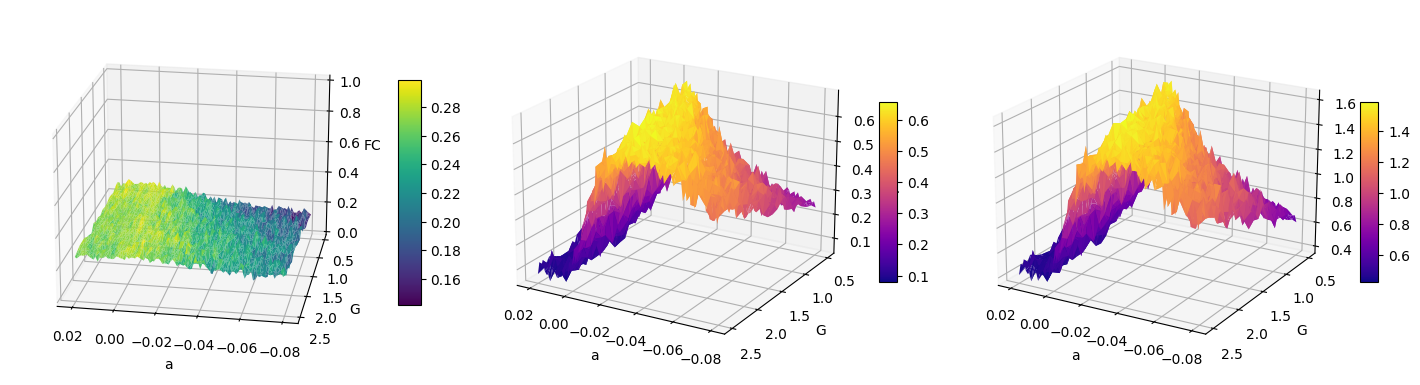

In [316]:
plot_3d_maps(df_mean_hc)

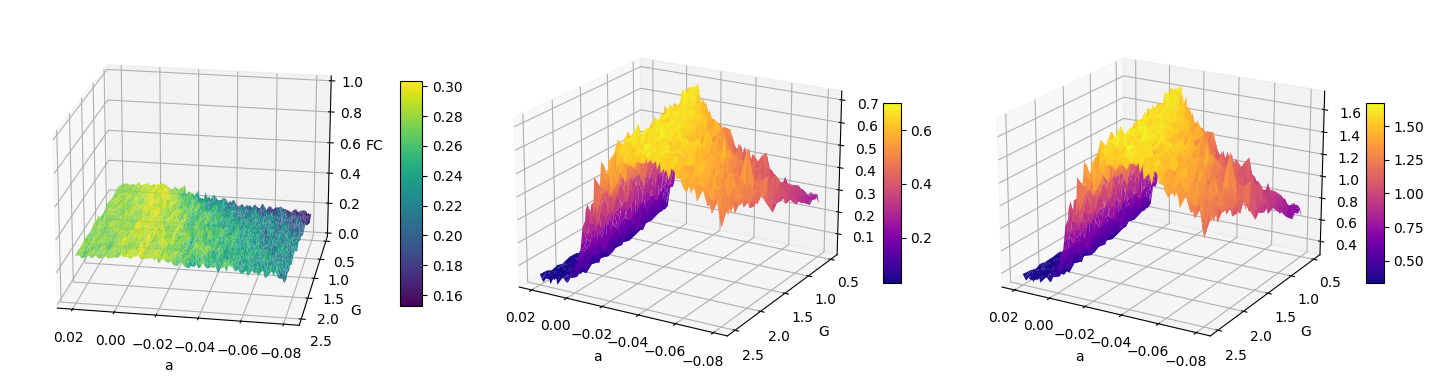

In [317]:
plot_3d_maps(df_mean_mci)

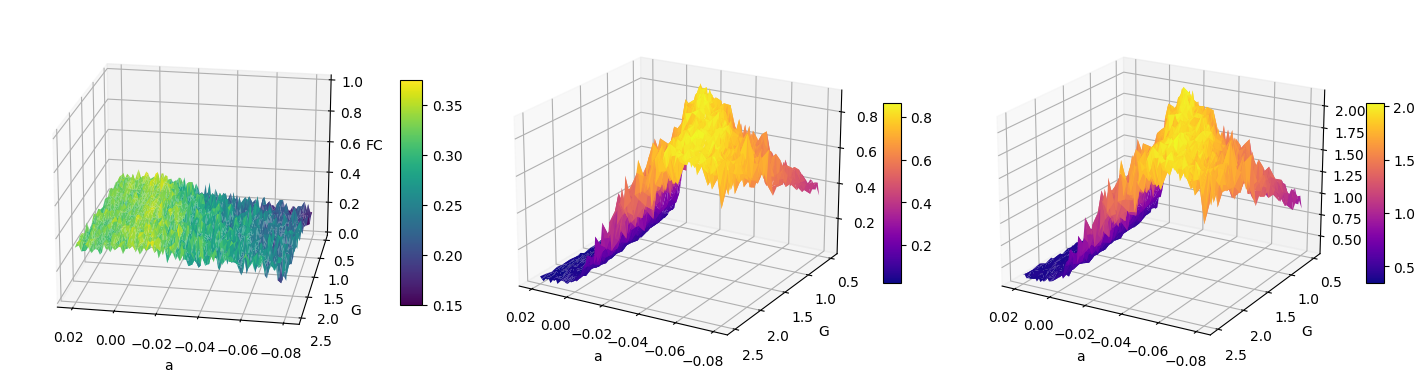

In [318]:
plot_3d_maps(df_mean_subj)